*In this file, we seek to automate parametrisation, running and results extraction of the osemosys project*

In [2]:
import subprocess
import os
from pathlib import Path
import gdxpds
import pandas as pd
import matplotlib.pyplot as plt
import re
from gdxpds import to_dataframes
import numpy as np
import seaborn as sns

# Define paths
gams_model = "osemosys.gms"
results_folder = Path("Results")
results_folder.mkdir(exist_ok=True)

In [3]:
#user-defined declarations
###### TO CHANGE ######
results_folder = "Results" #path to results folder
osemosys_exe = os.path.join(os.getcwd(),"osemosys.gms") #path to OSeMOSYS model
selected_file = ["py_parametrised", "template", "yes"] #
#######################

def extract_results(selected_file):
    """
    Loads corresponding gdx file into a an ordered dict of pandas dataframes.
    """
    print("Loading results...")
    results = []
    results_dir = os.path.join(os.getcwd(), results_folder)
    pattern = re.compile(r"results_SCEN(?P<scen>\w+)_DATA(?P<data>\w+)_STOR(?P<stor>yes|no)\.gdx")

    file_lookup = {}
    for filename in os.listdir(results_dir):

        match = pattern.match(filename)
        if match:
            key = (match.group("scen"), match.group("data"), match.group("stor"))
            file_lookup[key] = os.path.join(results_dir, filename)
    
    # Check if the selected file exists in the lookup
    key = tuple(selected_file)
    if key in file_lookup:
        filename = file_lookup[key]
        print(filename)
        results = to_dataframes(filename)
    else:
        print(f"{key} not found")
        results = None

    return results 

In [13]:
sns.set_theme(style="whitegrid", font_scale=1.3)
from matplotlib.ticker import MaxNLocator
from collections import OrderedDict

#functions, utilities
def plot_name(df, target, y_col="Level", x_col=None, title=None):
    if x_col is None:
        x_col = "YEAR"
    xlabel = x_col
    ylabel = y_col

    fig, ax = plt.subplots(figsize=(16, 10))

    if target != None:
        all_targets = sorted(df[target].unique())
        palette = sns.color_palette("tab20", n_colors=len(df[target].unique()))
        colour_map = dict(zip(all_targets, palette))

        df = df.pivot_table(index='YEAR', columns=target, values='Level', aggfunc='sum', fill_value=0)


        for col in df.columns:
            if col[:3] == "VIR" or col[:3] == "IMP":
                continue
            if (df[col] != 0).any():
                ax.plot(df.index, df[col], label=col, color=colour_map[col], linewidth=2)
    else:
        ax.plot(df["YEAR"], df[y_col], label=title, linewidth=2)
        
    ax.set_xlabel(xlabel if xlabel else x_col)
    ax.set_ylabel(ylabel if ylabel else y_col)
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Reduce overcrowding on x-axis
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(f"{title if title else None}", fontsize=14)
    plt.legend()
    fig.tight_layout()
    plt.show()


def plot_allusefulcharts(gdx_f, filter=None):
    x_col = "YEAR"
    y_col = "Level"

    TechnologyPlots = ["ProductionByTechnologyAnnual", "ProductionByTechnology", "CapitalInvestment", 
    "UseByTechnologyAnnual","OperatingCost", "RateOfProductionByTechnology", "RateOfTotalActivity", 
    "OperatingCost", "AnnualTechnologyEmission", "TotalCapacityAnnual"]
    FuelPlots = ["RateOfUse", "Trade", "UseAnnual"]
    StoragePlots = ["NewStorageCapacity", "CapitalInvestmentStorage", "StorageLevelYearStart", "StorageLevelYearFinish", "StorageUpperLimit"]
    EmissionPlots = ["AnnualEmissions"]

    singleplots = ["TotalDiscountedCost"]
    
    for t in TechnologyPlots:
        if filter!= None and t not in filter:
            continue
        df = gdx_f[t]
        df = df[df["Level"] > 0]
        plot_name(df, "TECHNOLOGY", y_col=y_col, x_col=x_col, title=t)

    for f in FuelPlots:
        if filter != None and f not in filter:
            continue
        df = gdx_f[f]
        df = df[df["Level"] > 0]
        plot_name(df, "FUEL", y_col=y_col, x_col=x_col, title=f)

    for s in StoragePlots:
        if filter != None and s not in filter:
            continue
        df = gdx_f[s]
        df = df[df["Level"] > 0]
        plot_name(df, "STORAGE", y_col=y_col, x_col=x_col, title=s)

    for e in EmissionPlots:
        if filter != None and e not in filter:
            continue
        df = gdx_f[e]
        df = df[df["Level"] > 0]
        plot_name(df, "EMISSION", y_col=y_col, x_col=x_col, title=e)

    for single in singleplots:
        if filter != None and single not in filter:
            continue
        df = gdx_f[single]
        df = df[df["Level"] > 0]
        plot_name(df, None, y_col=y_col, x_col=x_col, title=single)

def run_extr_gams(scenario, data, storage, solvermode="mip", message=None):
    subprocess.run([
        "gams",
        gams_model,
        f"--scen={scenario}",
        f"--data={data}",
        f"--storage={storage}"
        f"--solvermode={solvermode}"], check=True)
    
    res = extract_results(selected_file)
    return res

--- Job osemosys.gms Start 05/19/25 15:30:16 49.2.0 9b2b0844 DAX-DAC arm 64bit/macOS
--- Applying:
    /Library/Frameworks/GAMS.framework/Versions/49/Resources/gmsprmun.txt
--- GAMS Parameters defined
    Input /Users/hugosmart/Documents/Github/Hy-run/osemosys.gms
    ScrDir /Users/hugosmart/Documents/Github/Hy-run/225e/
    SysDir /Library/Frameworks/GAMS.framework/Versions/49/Resources/
    --scen py_parametrised
    --data template
    --storage yes--solvermode=mip
Licensee: Massimo Tavoni                                 G250226+0003Ac-GEN
          Fondazione CMCC                                           DCE4109
          225e/gamslice.dat
          node:56901401 mem:8 cores:8 ipport:50477 v:2                     
          Course license for use within the course and related course work
          The expiration date of time-limited license is Sep 24, 2025
System information: 8 physical cores and 8 Gb memory detected
GAMS 49.2.0   Copyright (C) 1987-2025 GAMS Development. All righ

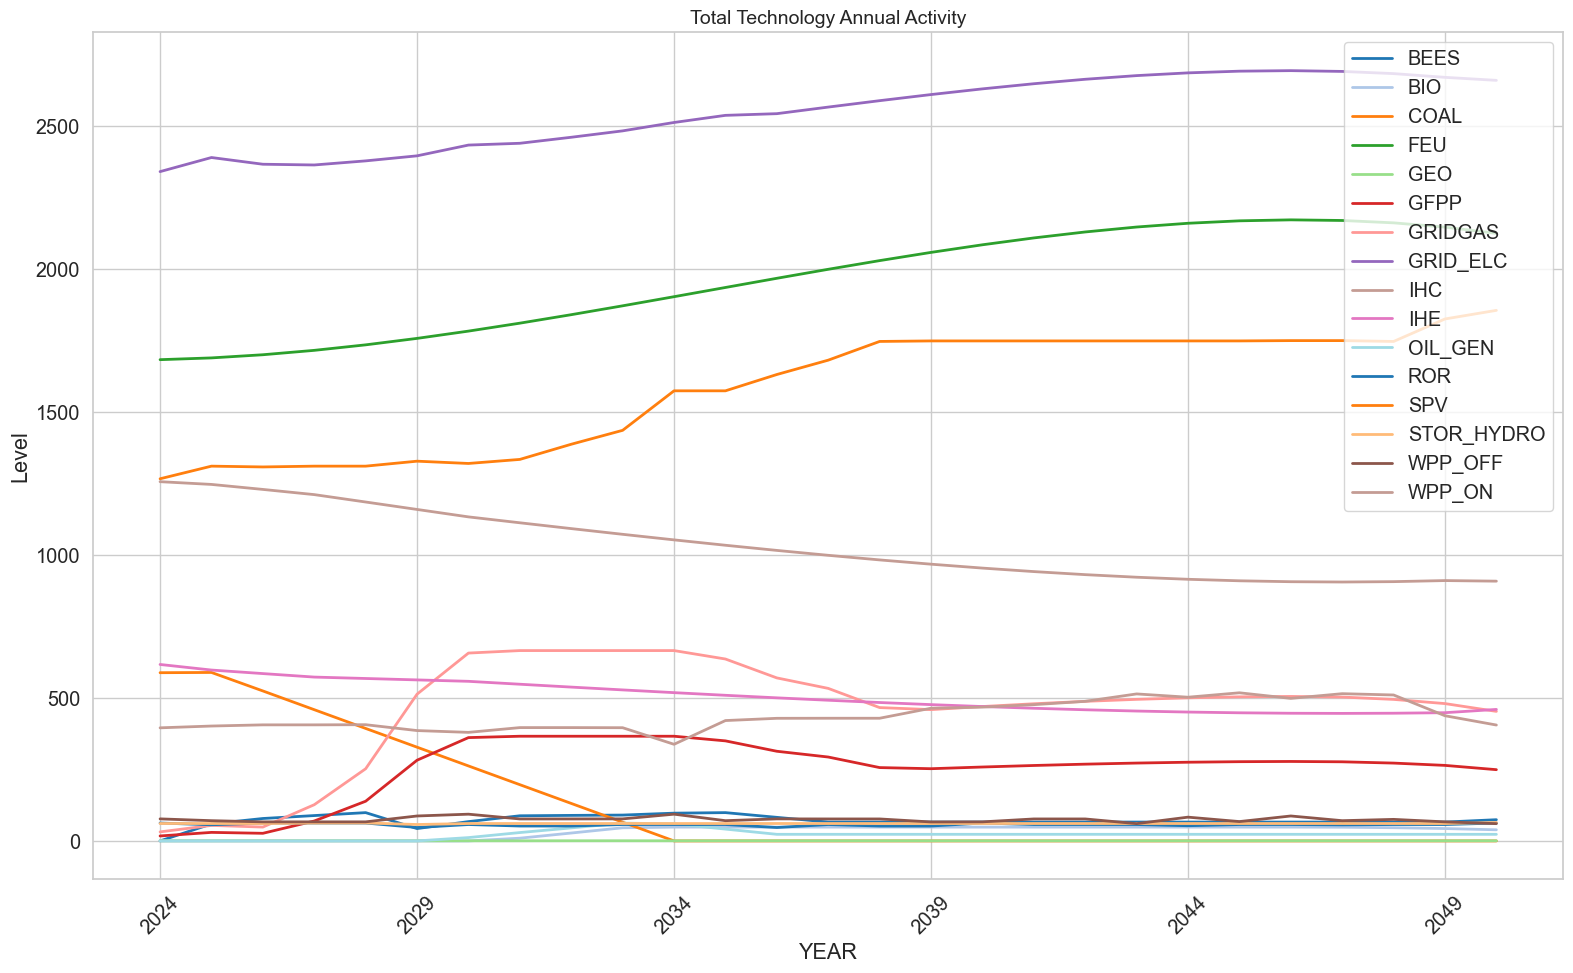

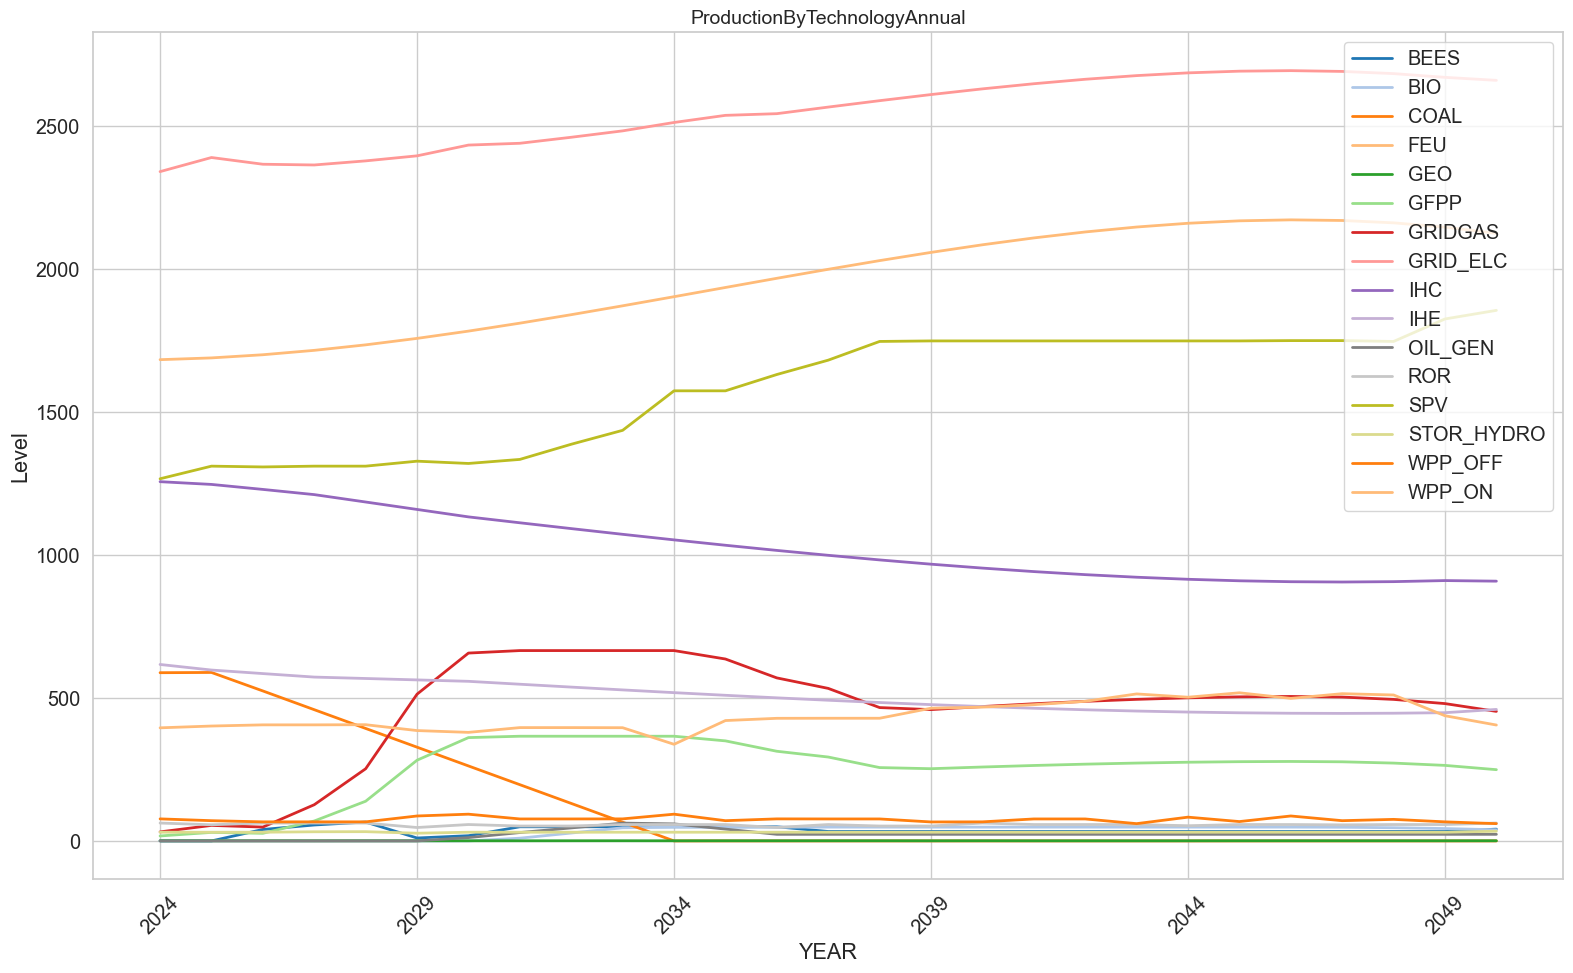

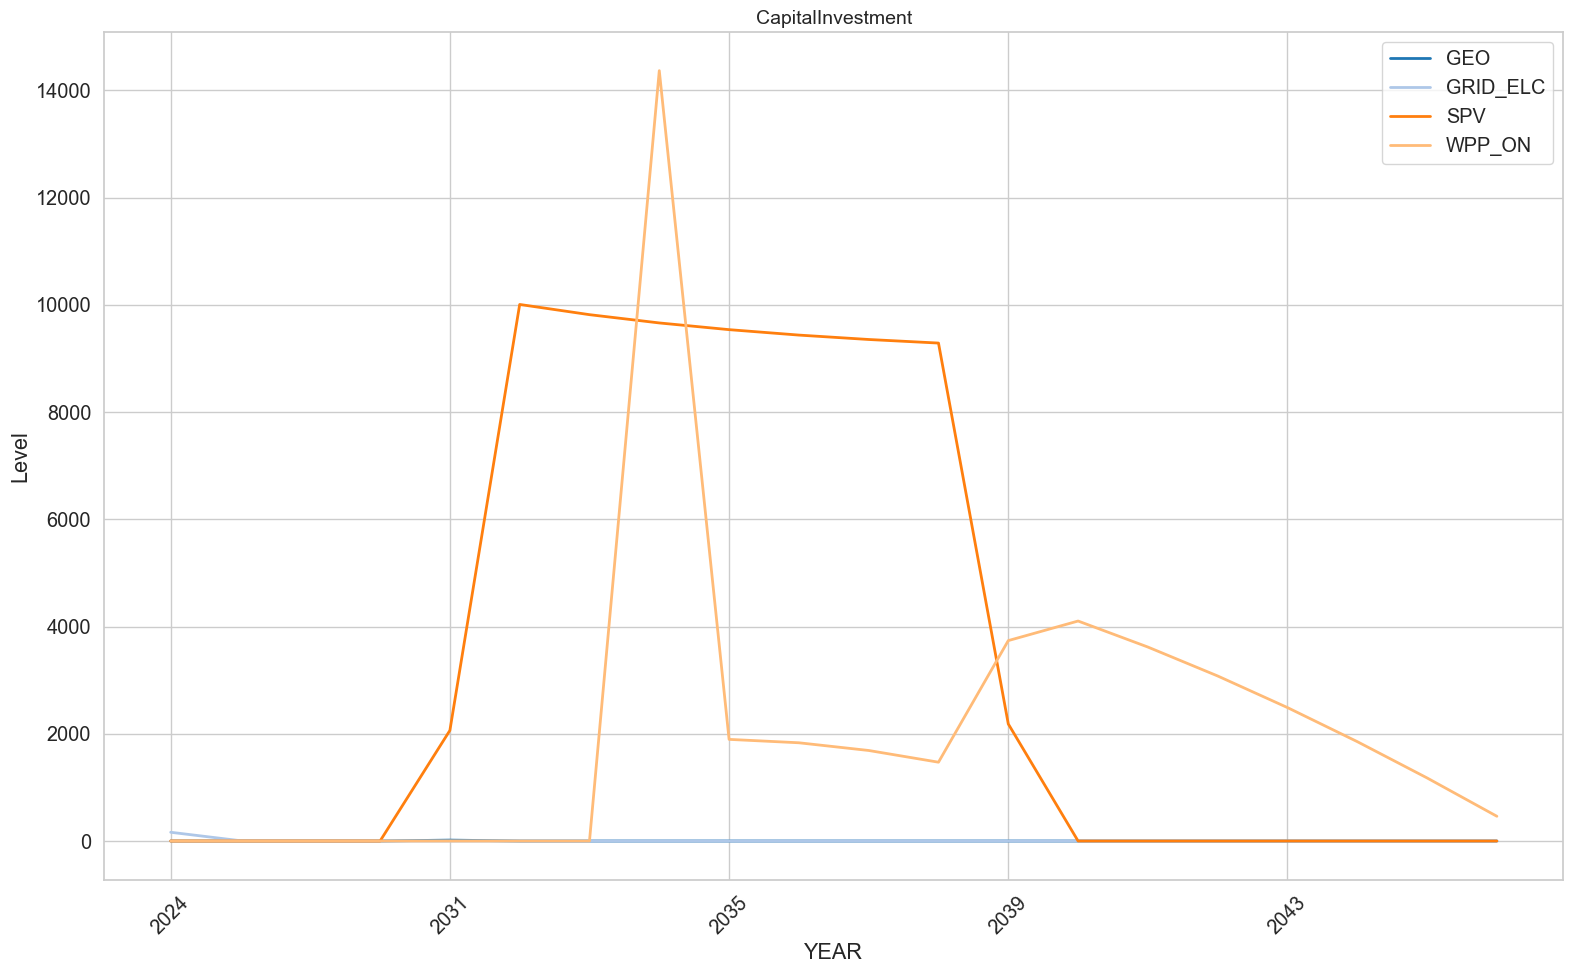

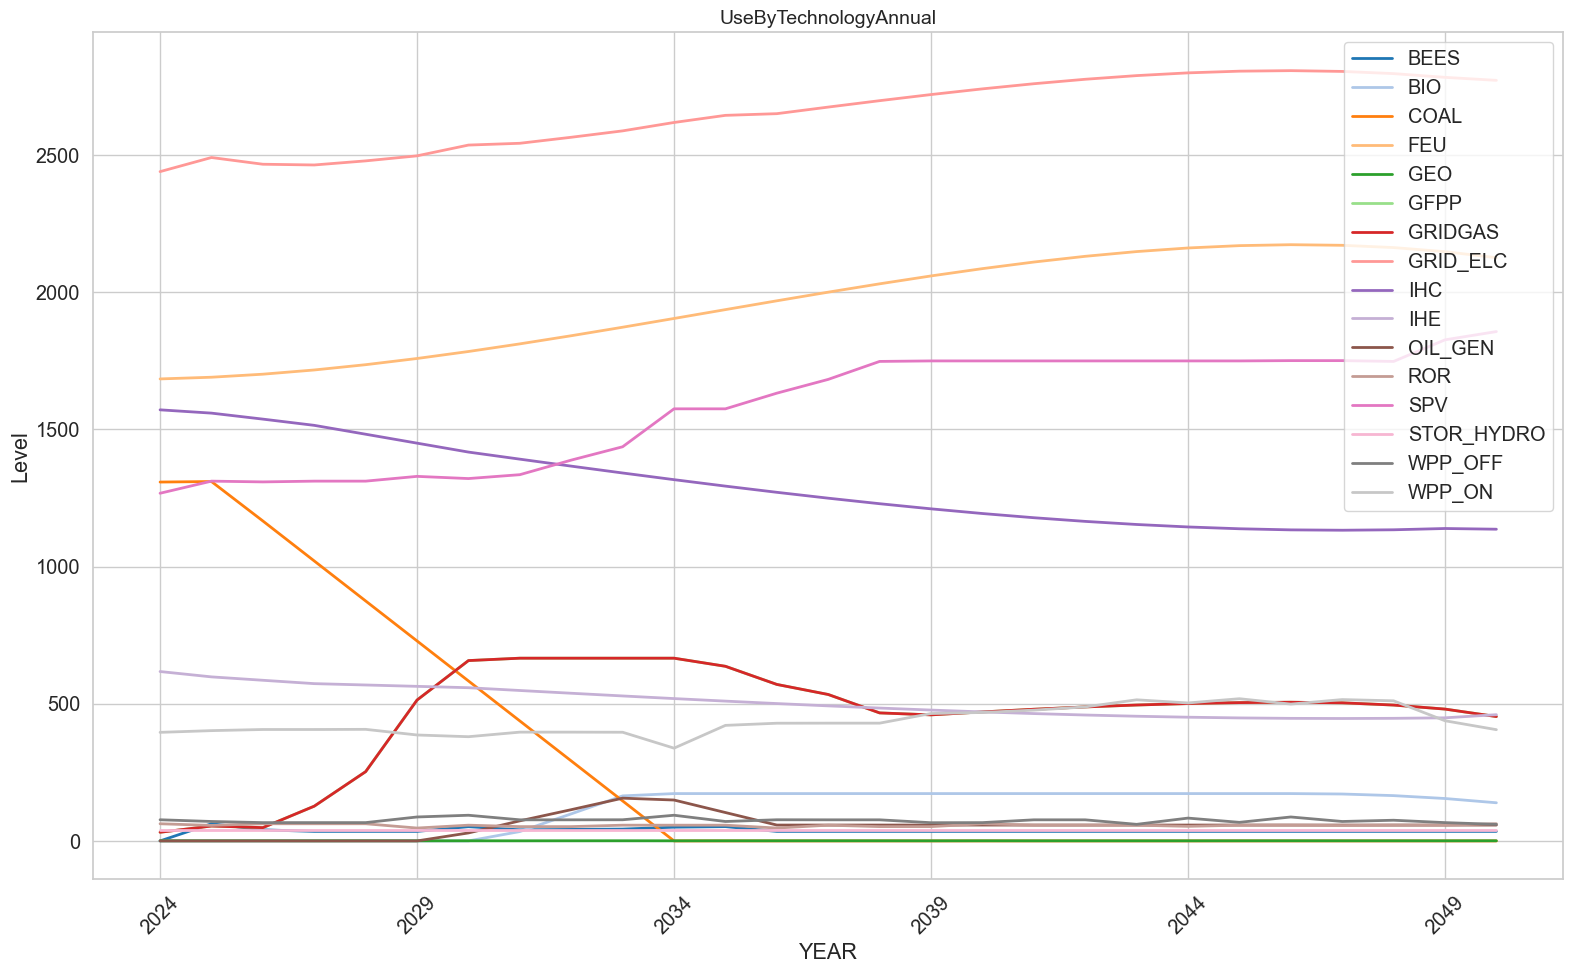

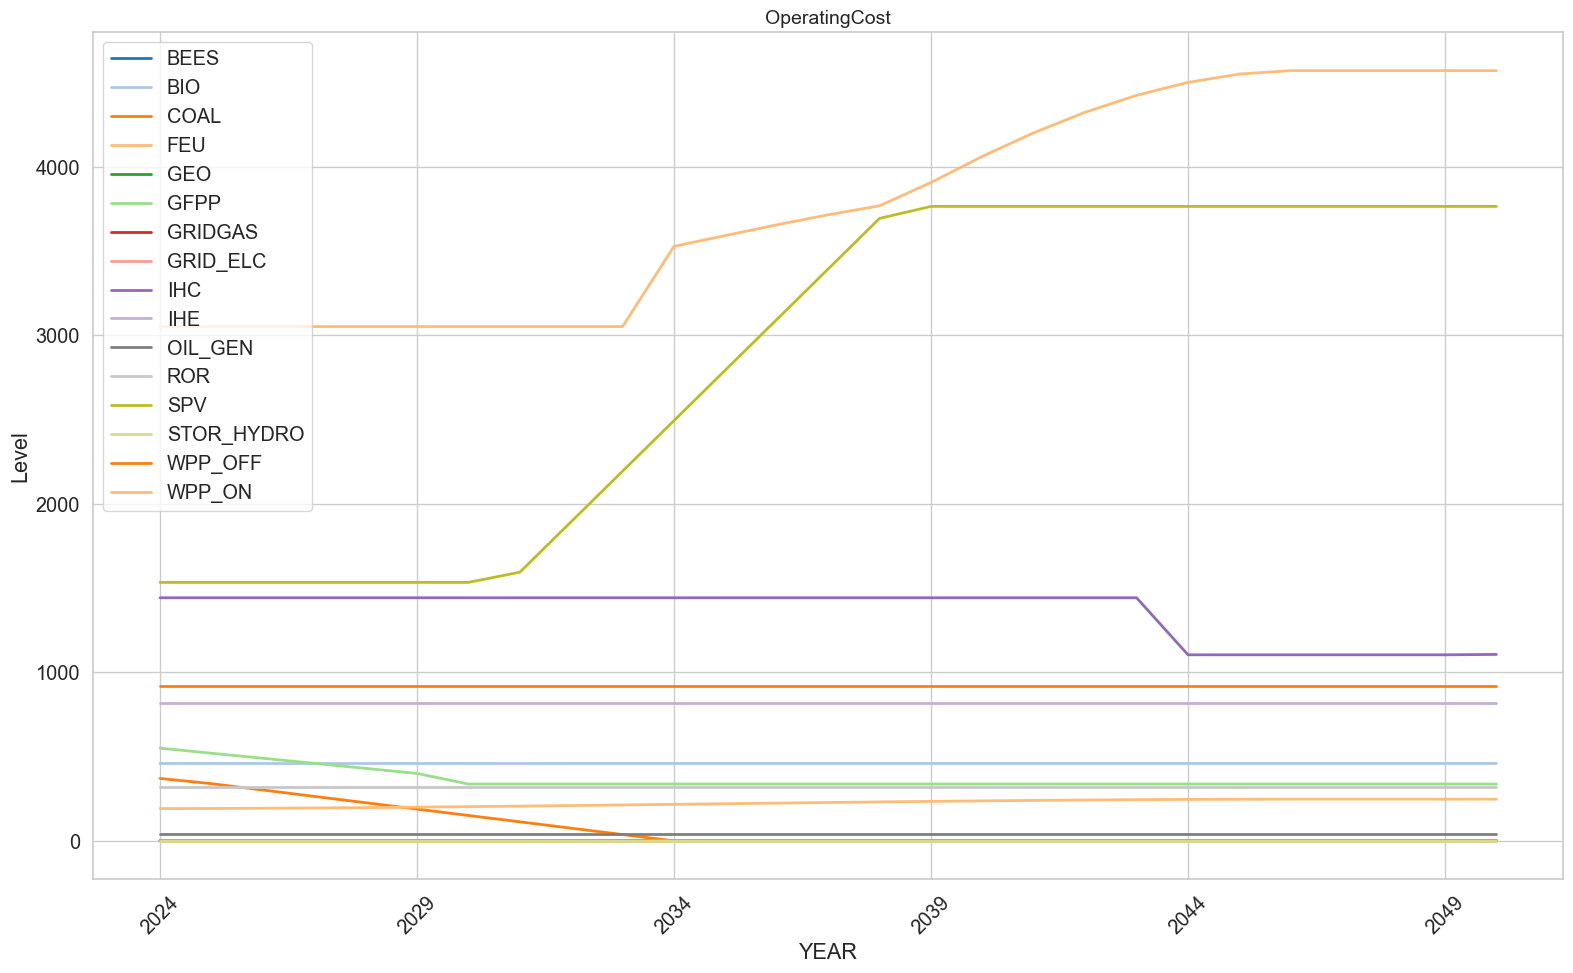

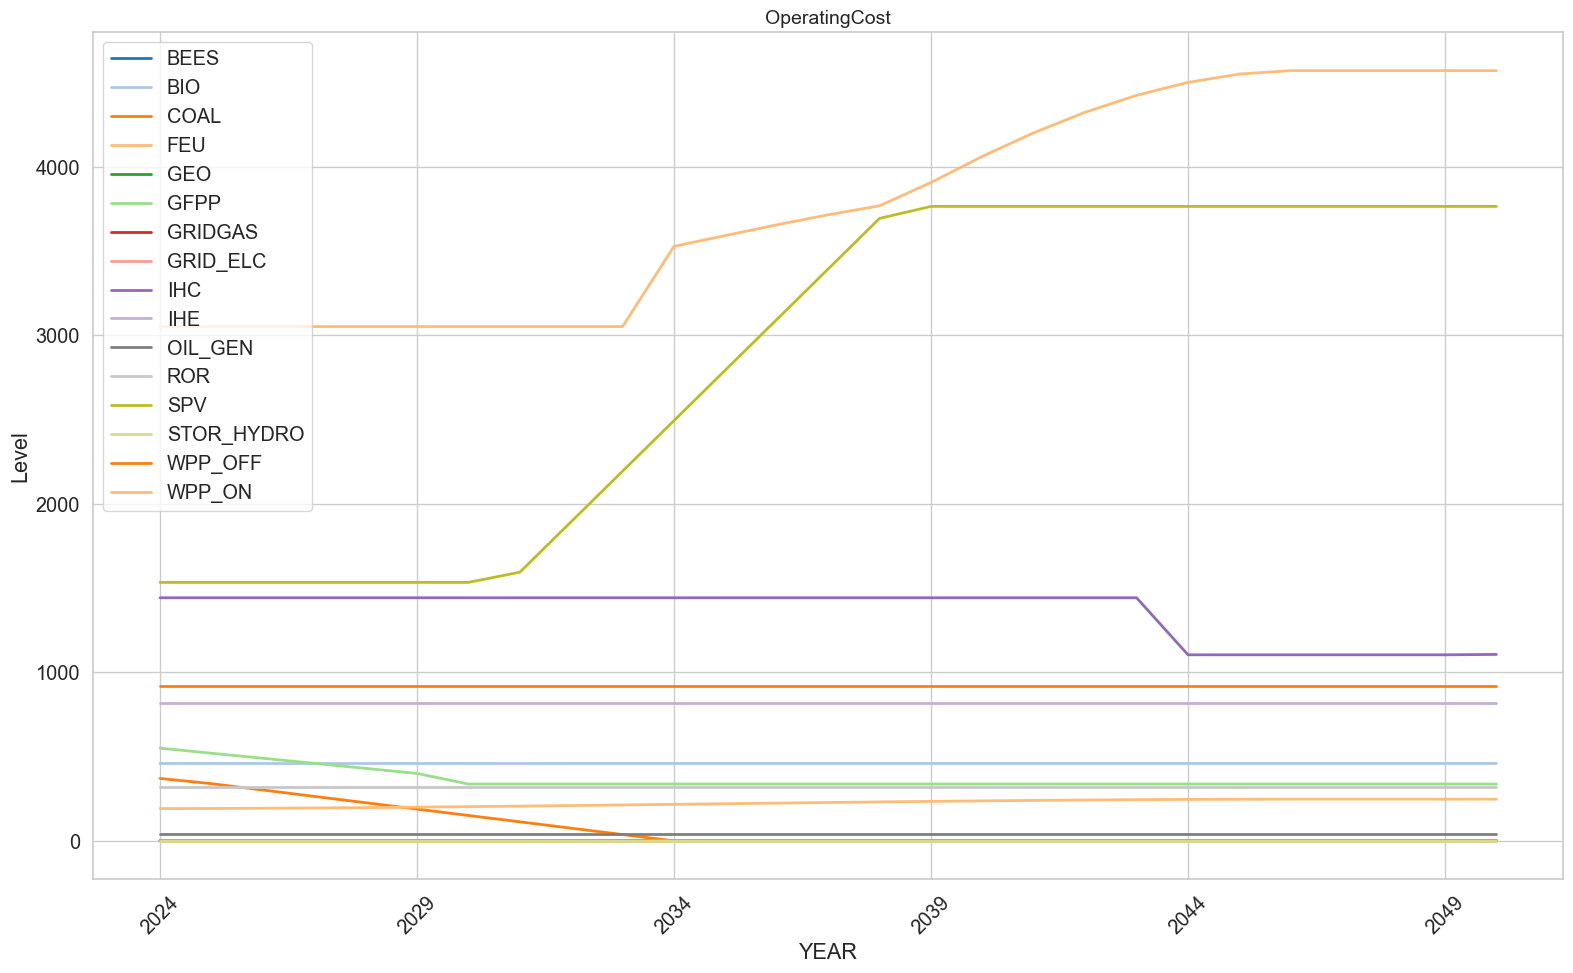

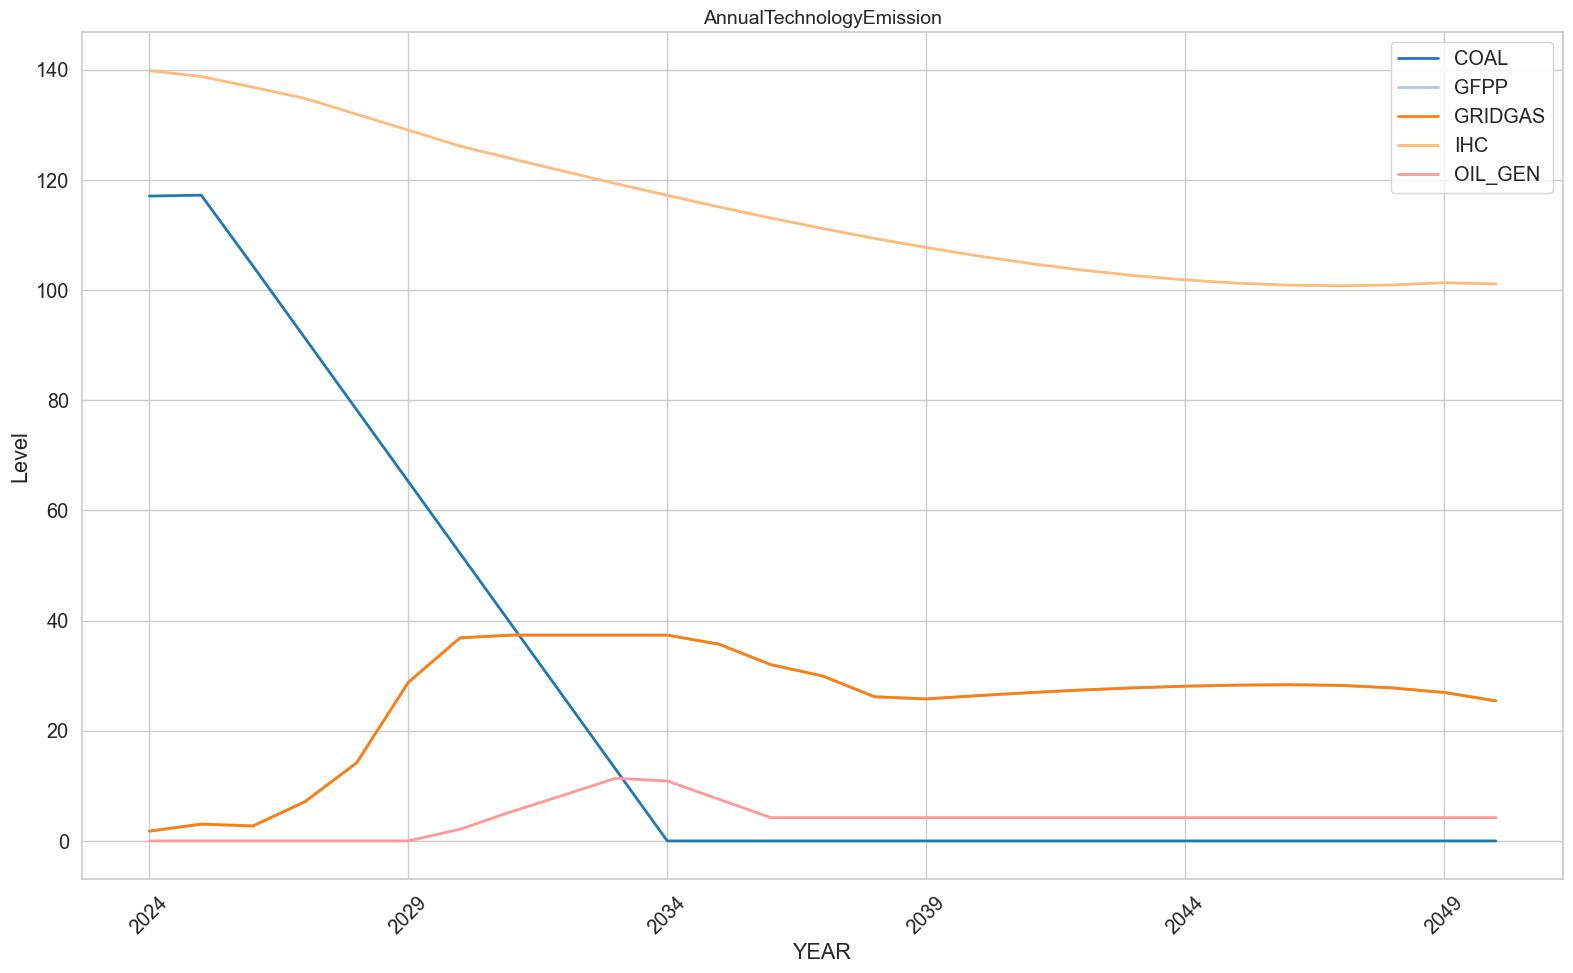

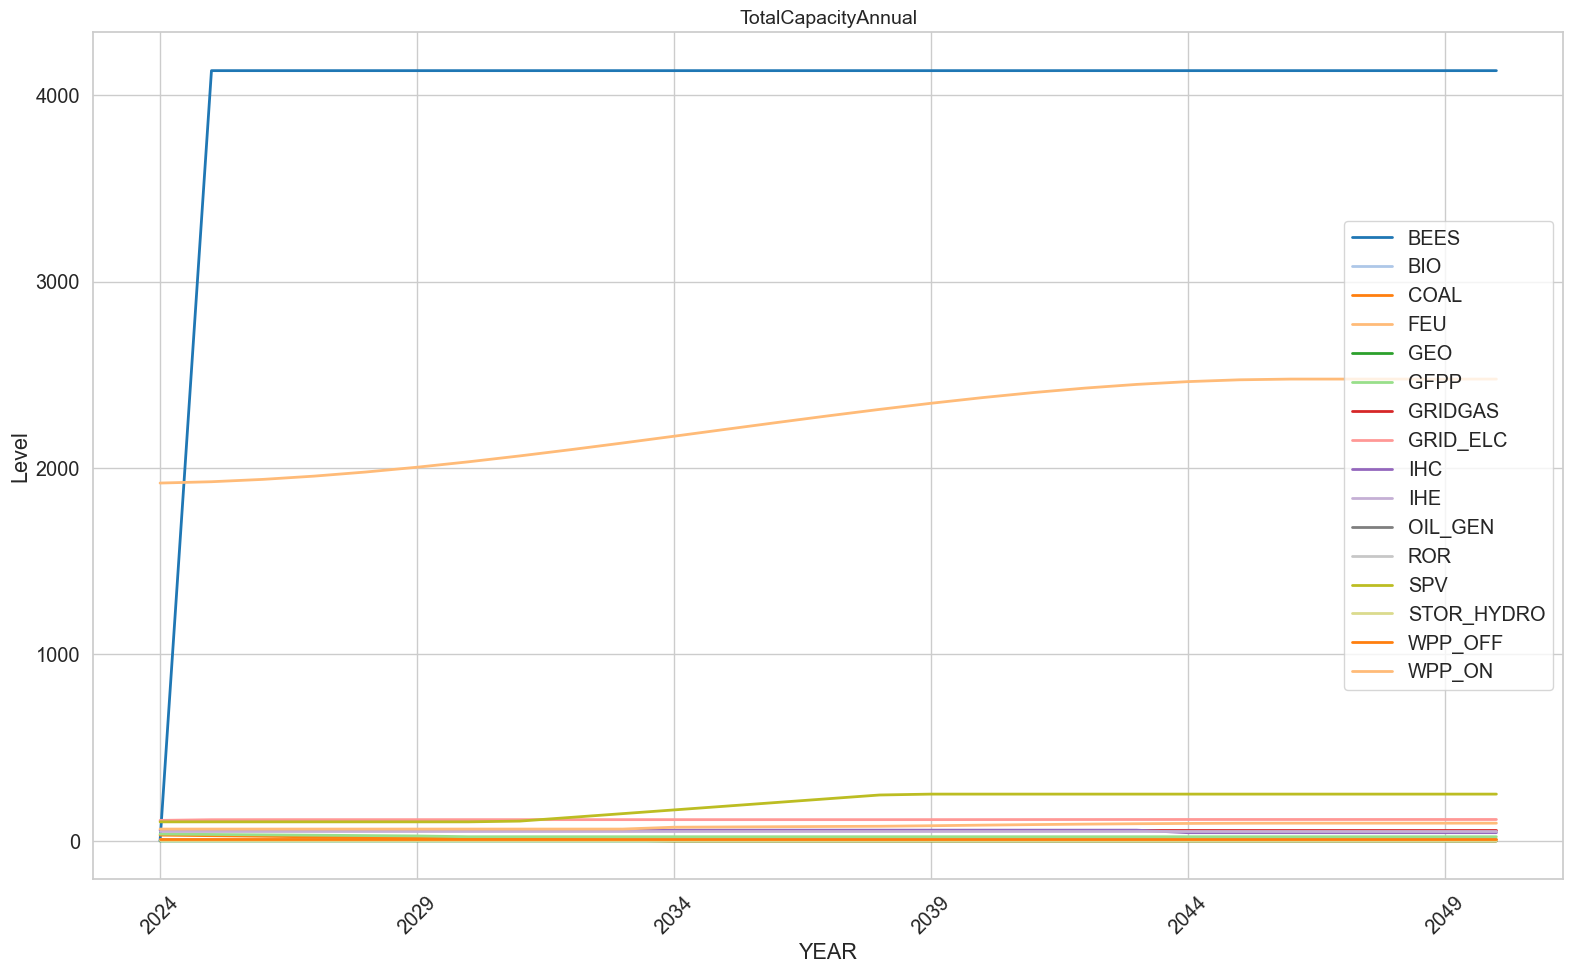

/var/folders/q5/nnfydg7n1mg81hpylzsk6lqh0000gn/T/ipykernel_83917/2824607794.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


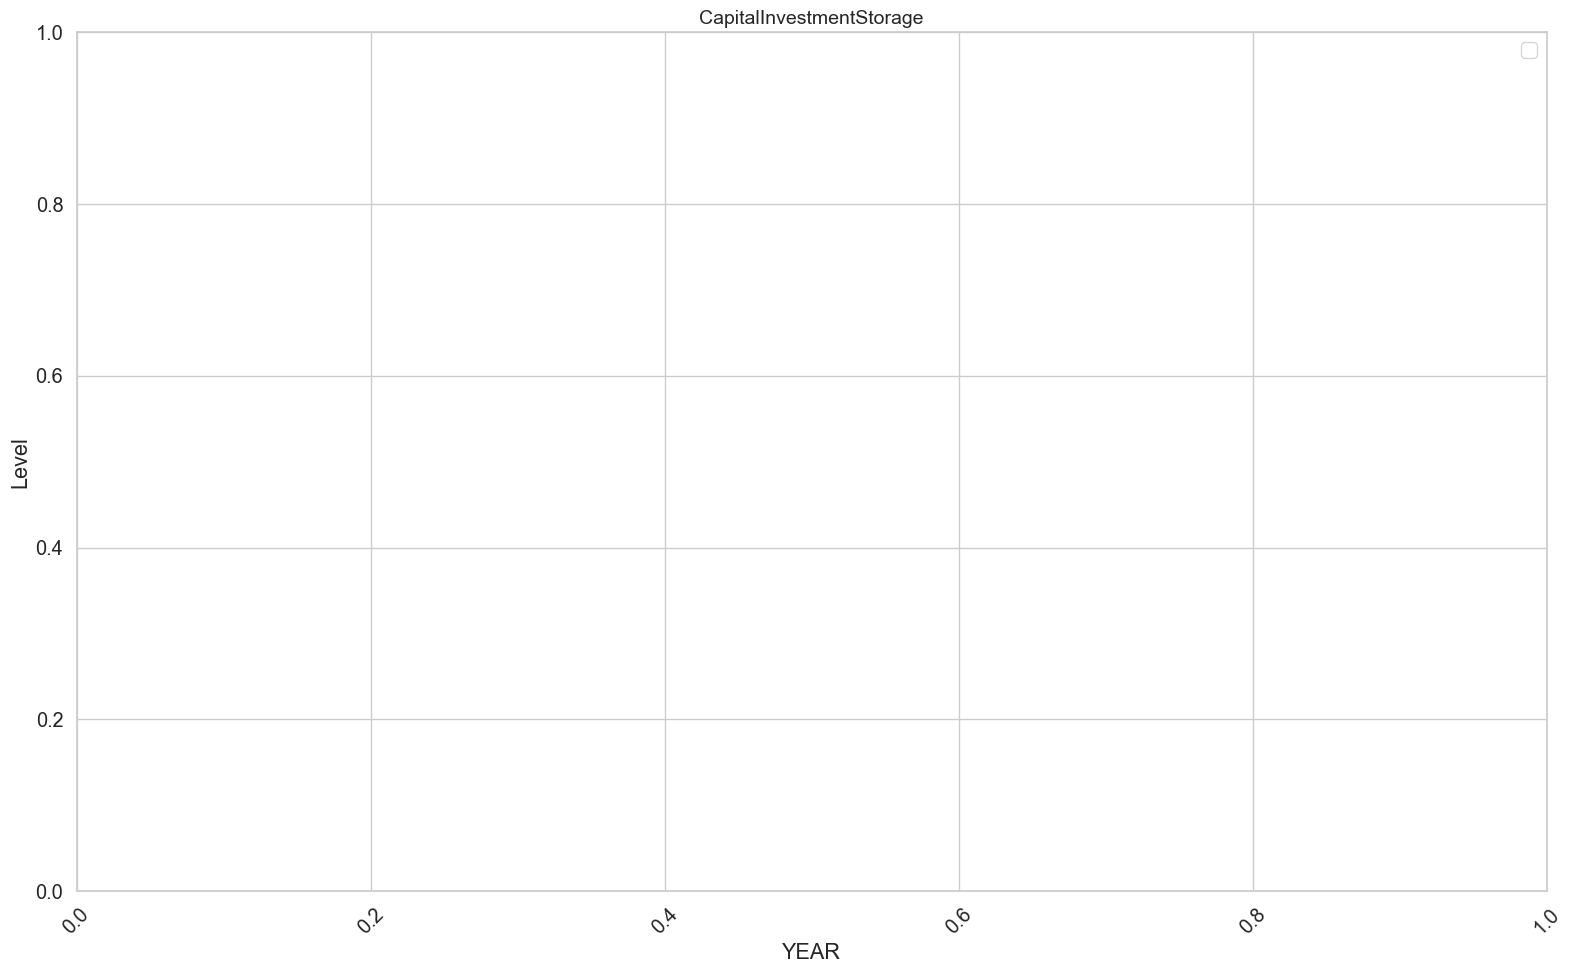

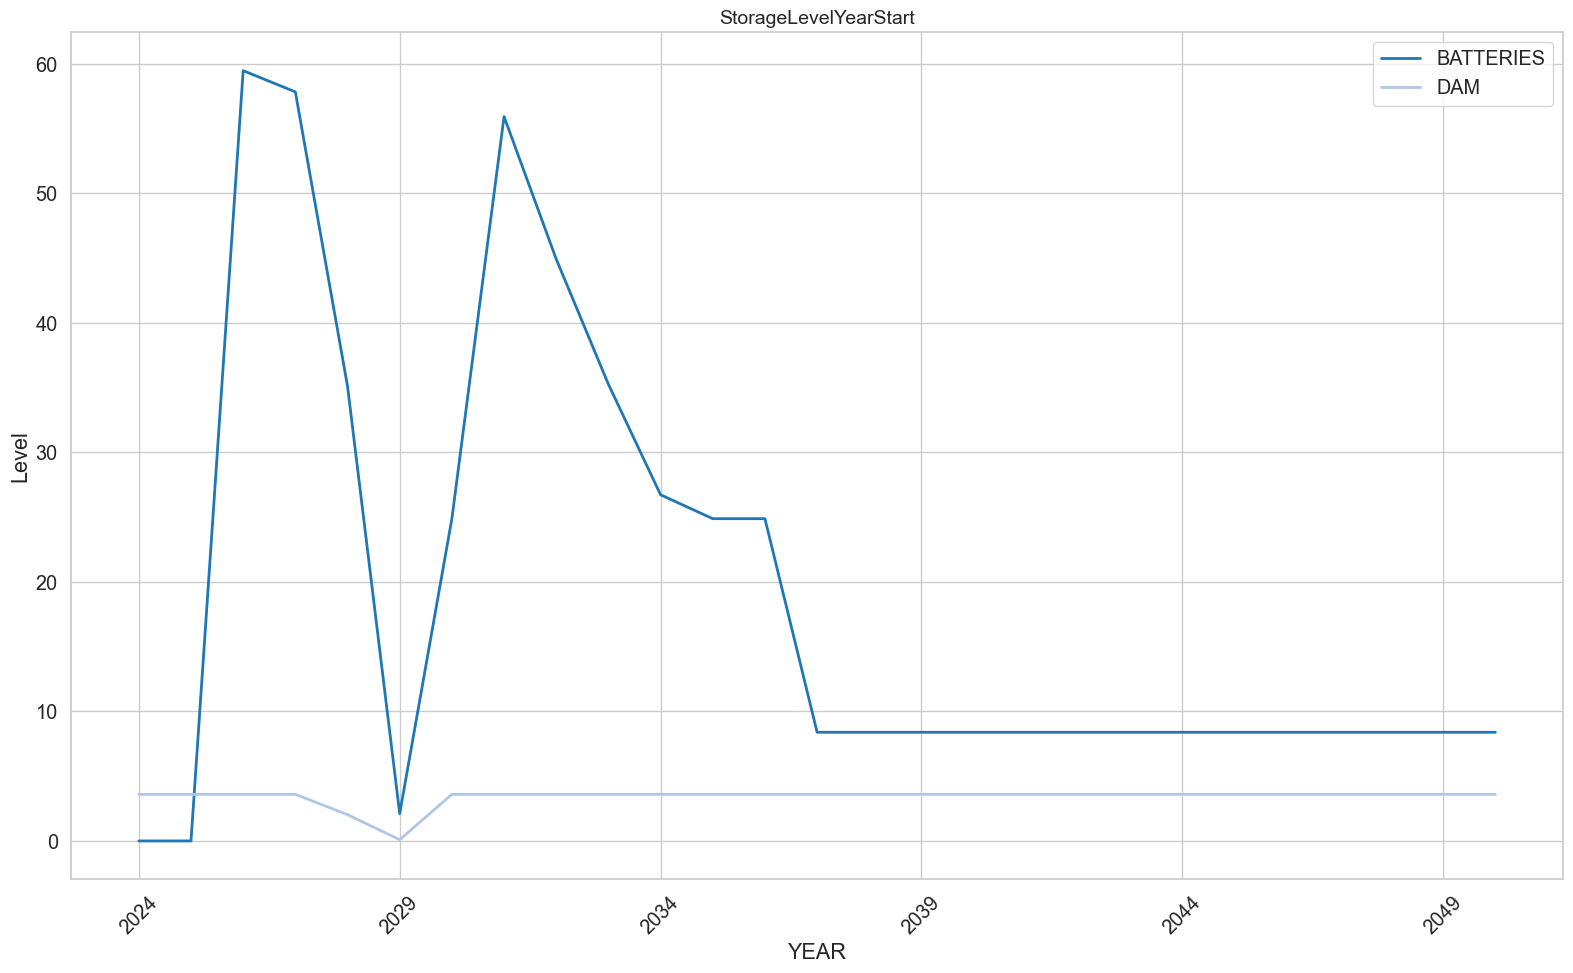

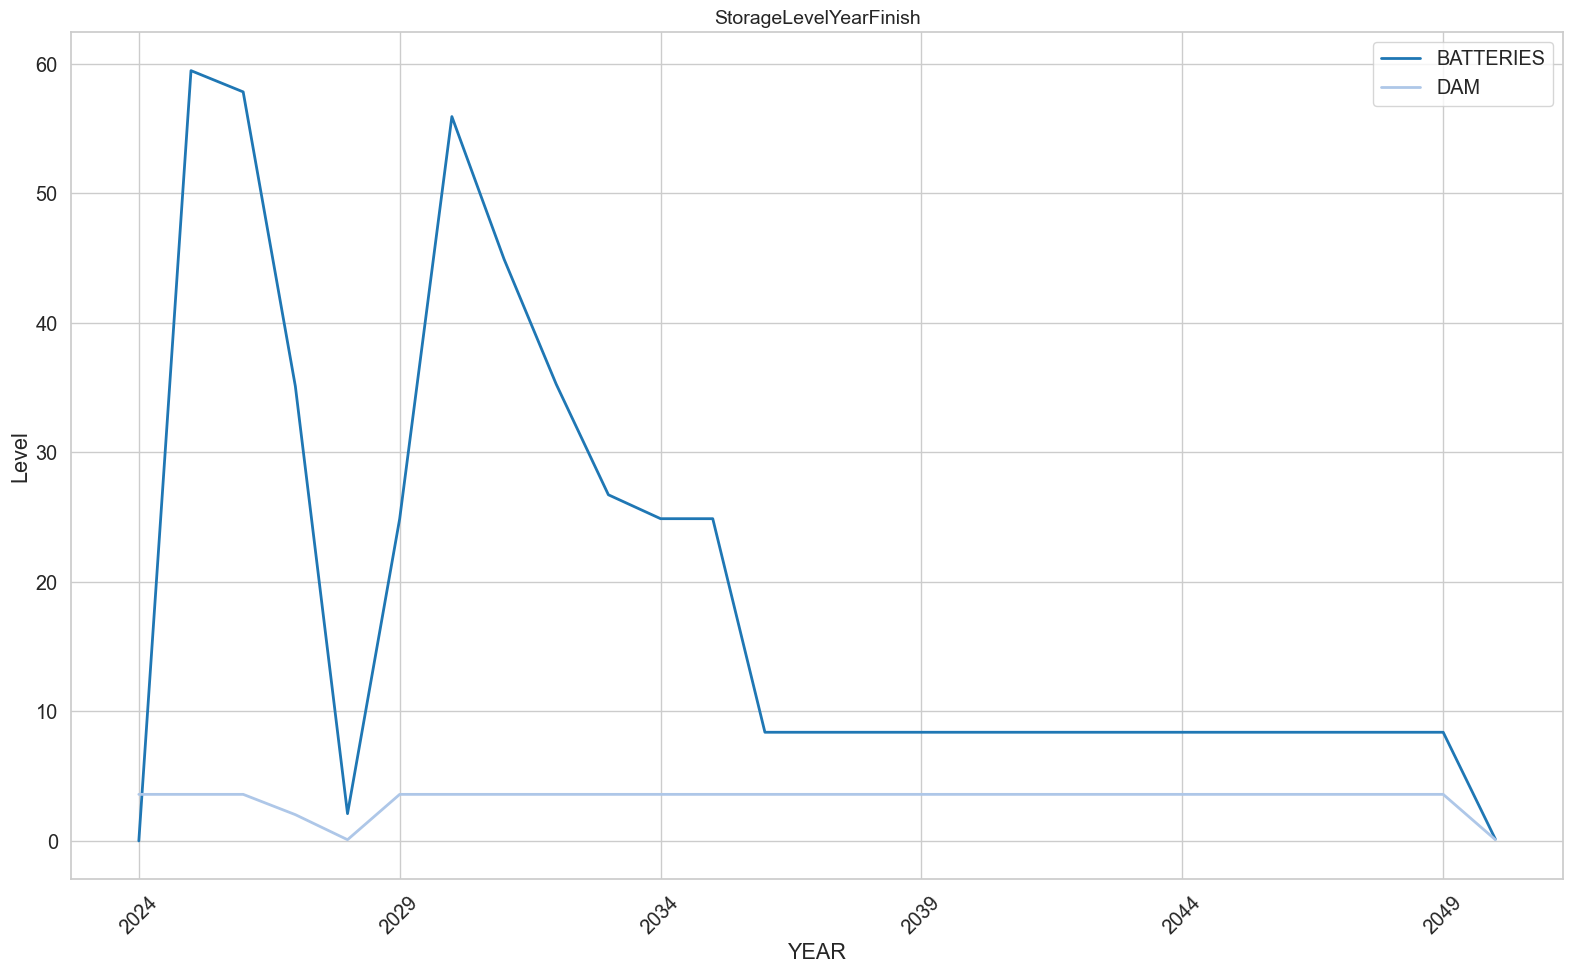

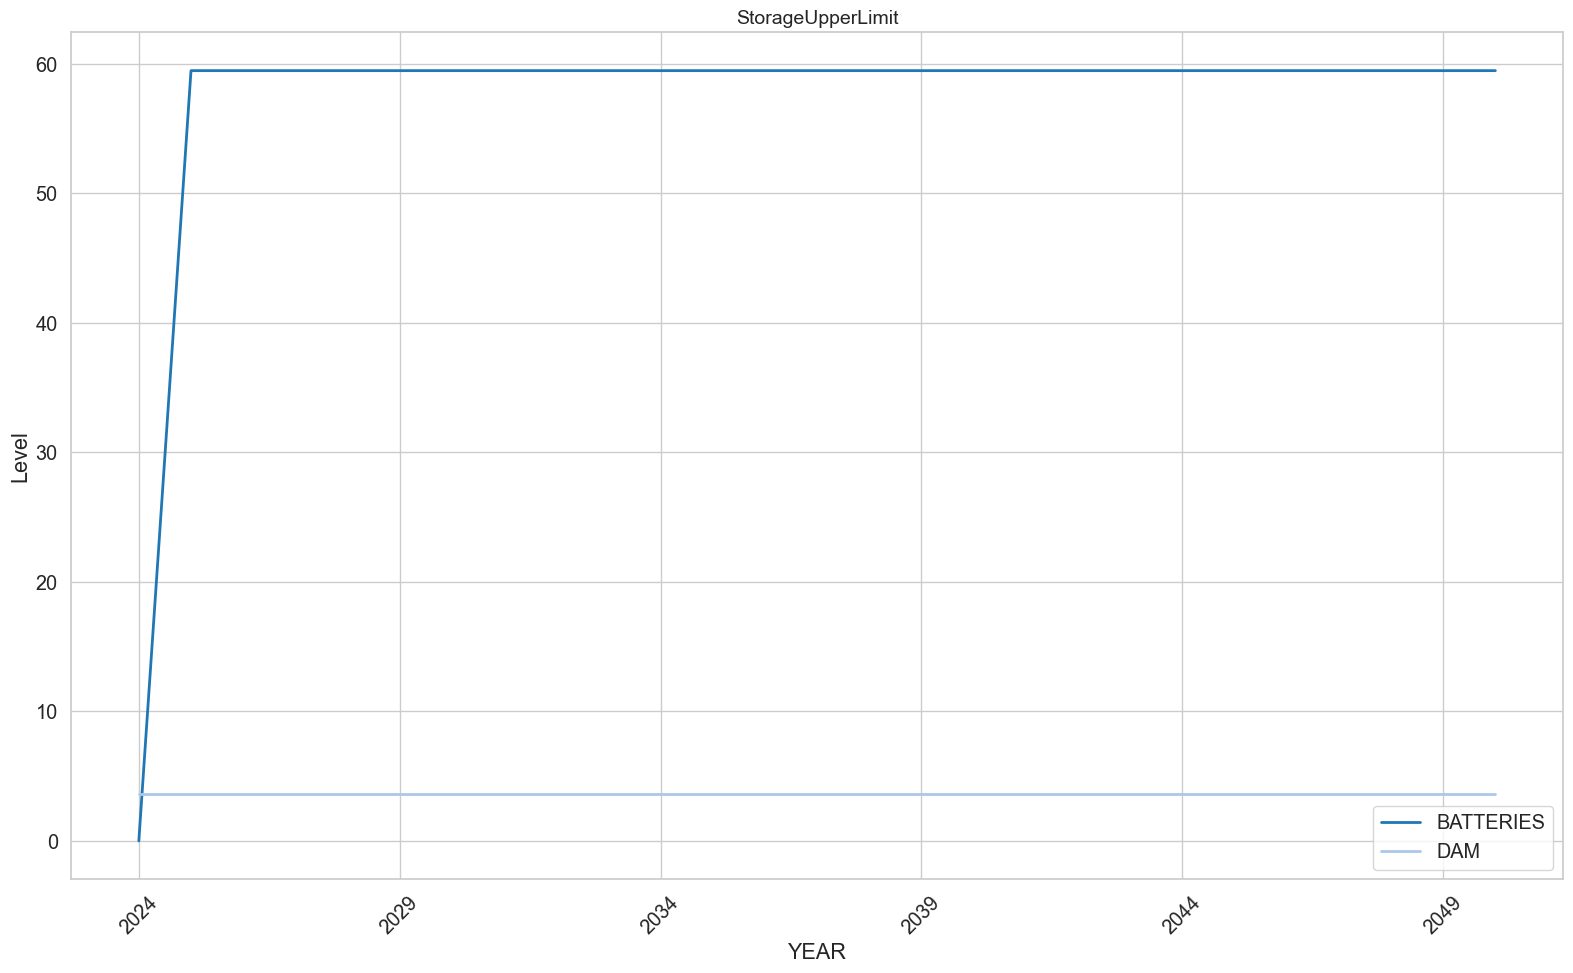

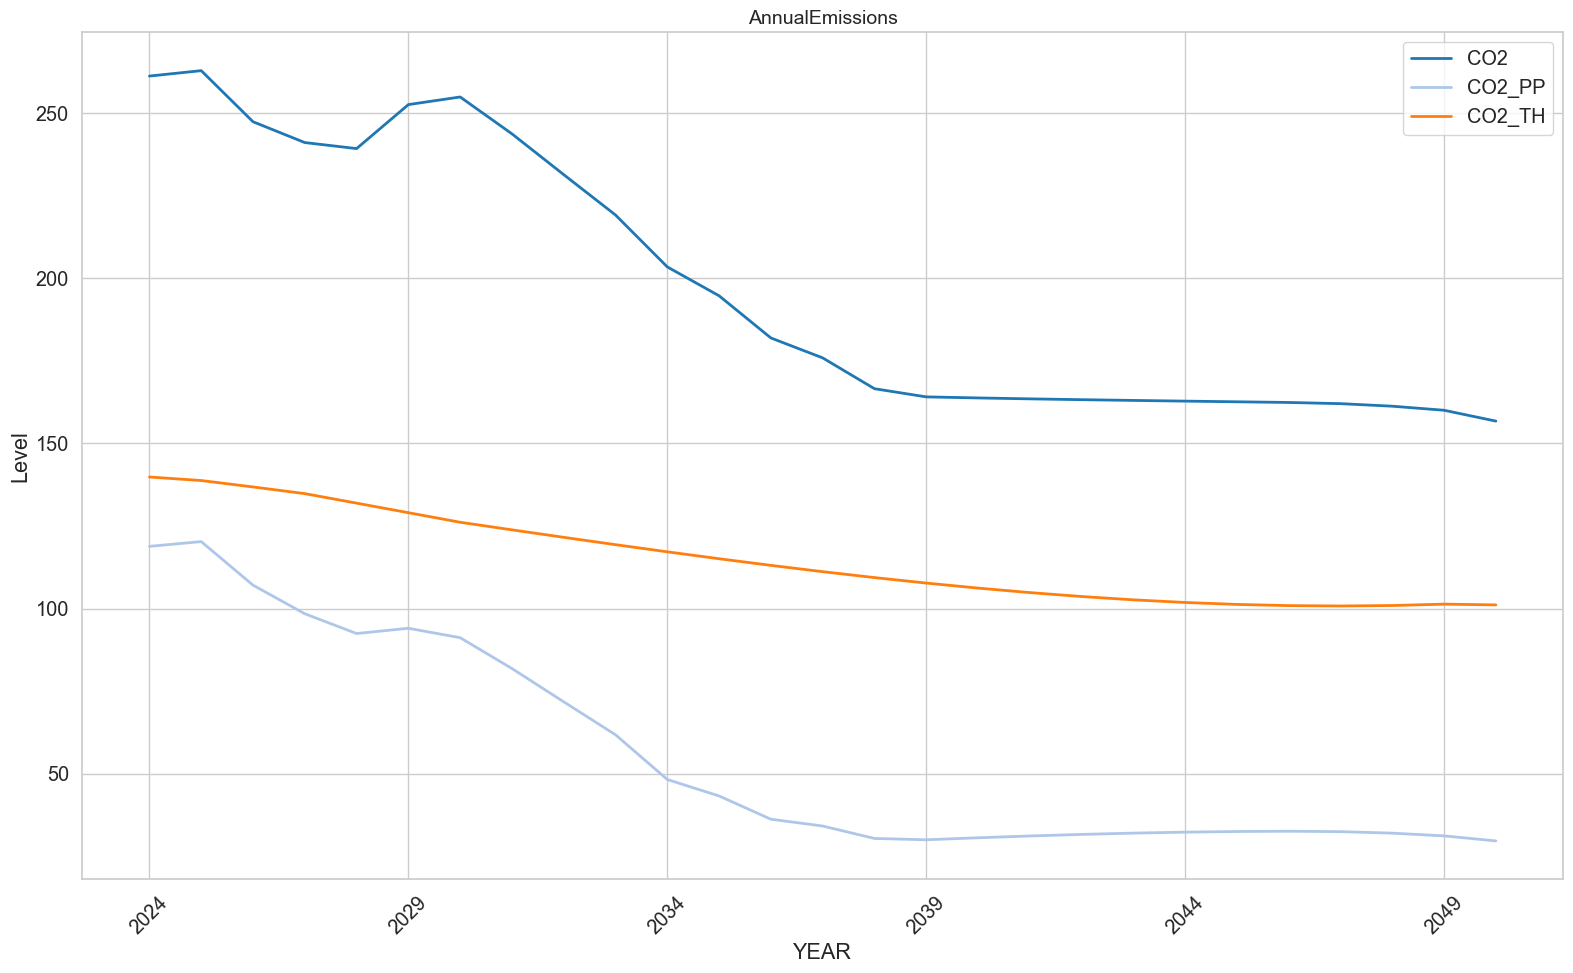

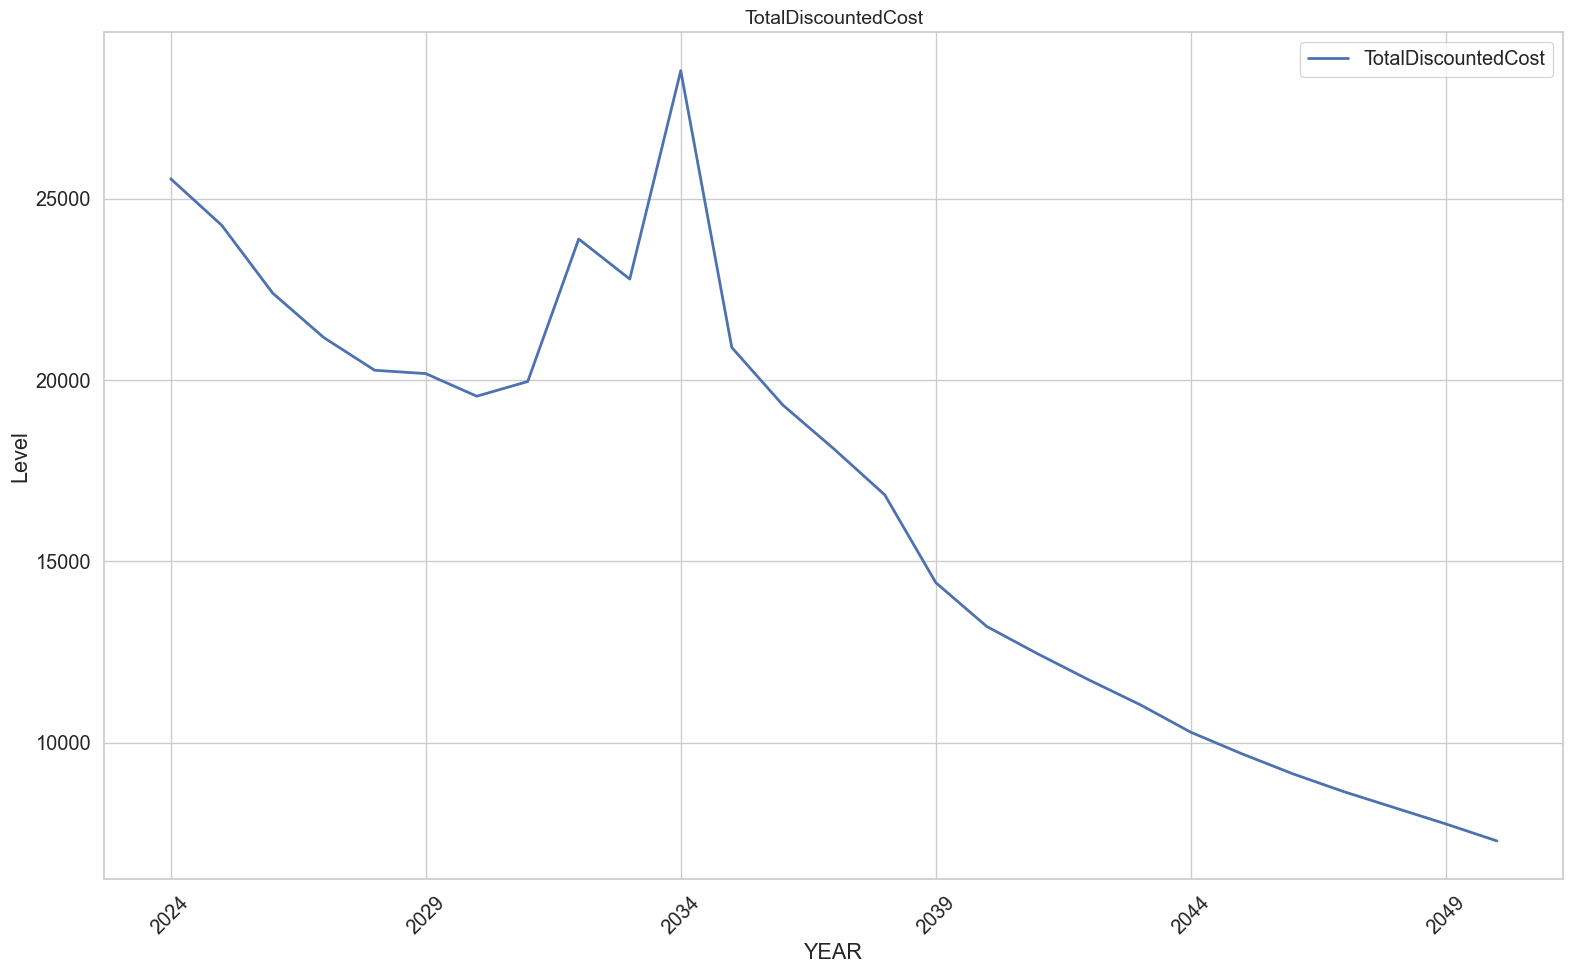

In [14]:
# Example usage:
ordereddict = run_extr_gams(*selected_file)
df_toplot = ordereddict["TotalTechnologyAnnualActivity"]
plot_name(df_toplot, target="TECHNOLOGY", y_col="Level", x_col="YEAR", title="Total Technology Annual Activity")

listmichele = [
    "AnnualEmissions", "AnnualTechnologyEmission", "CapitalInvestment",
    "CapitalInvestmentStorage", "OperatingCost", "ProductionByTechnologyAnnual",
    "StorageLevelYearStart", "StorageLevelYearFinish", "StorageUpperLimit",
    "TotalCapacityAnnual", "UseByTechnologyAnnual", "TotalDiscountedCost",
    #"StorageLevelSeasonStart", "StorageLevelDayTypeStart"
]

#or plot all useful charts, helping me populate the "useful charts"
plot_allusefulcharts(ordereddict, filter=listmichele)